In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import PIL

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.utils.data as data
import torchvision

import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw
import torch.nn.functional as F
import matplotlib.gridspec as gridspec
import torch.optim as optim

In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function
from builtins import range
import urllib.request, urllib.error, urllib.parse, os, tempfile

import numpy as np
import imageio

"""
Utility functions used for viewing and processing images.
"""

def blur_image(X):
    """
    A very gentle image blurring operation, to be used as a regularizer for
    image generation.

    Inputs:
    - X: Image data of shape (N, 3, H, W)

    Returns:
    - X_blur: Blurred version of X, of shape (N, 3, H, W)
    """
    from cs231n.fast_layers import conv_forward_fast
    w_blur = np.zeros((3, 3, 3, 3))
    b_blur = np.zeros(3)
    blur_param = {'stride': 1, 'pad': 1}
    for i in range(3):
        w_blur[i, i] = np.asarray([[1, 2, 1], [2, 188, 2], [1, 2, 1]],
                                  dtype=np.float32)
    w_blur /= 200.0
    return conv_forward_fast(X, w_blur, b_blur, blur_param)[0]


SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_image(img):
    """Preprocess an image for squeezenet.
    
    Subtracts the pixel mean and divides by the standard deviation.
    """
    return (img.astype(np.float32)/255.0 - SQUEEZENET_MEAN) / SQUEEZENET_STD


def deprocess_image(img, rescale=False):
    """Undo preprocessing on an image and convert back to uint8."""
    img = (img * SQUEEZENET_STD + SQUEEZENET_MEAN)
    if rescale:
        vmin, vmax = img.min(), img.max()
        img = (img - vmin) / (vmax - vmin)
    return np.clip(255 * img, 0.0, 255.0).astype(np.uint8)


def image_from_url(url):
    """
    Read an image from a URL. Returns a numpy array with the pixel data.
    We write the image to a temporary file then read it back. Kinda gross.
    """
    try:
        f = urllib.request.urlopen(url)
        _, fname = tempfile.mkstemp()
        with open(fname, 'wb') as ff:
            ff.write(f.read())
        img = imread(fname)
        #os.remove(fname)
        return img
    except urllib.error.URLError as e:
        print('URL Error: ', e.reason, url)
    except urllib.error.HTTPError as e:
        print('HTTP Error: ', e.code, url)


def load_image(filename, size=None):
    """Load and resize an image from disk.

    Inputs:
    - filename: path to file
    - size: size of shortest dimension after rescaling
    """
    img = imread(filename)
    if size is not None:
        orig_shape = np.array(img.shape[:2])
        min_idx = np.argmin(orig_shape)
        scale_factor = float(size) / orig_shape[min_idx]
        new_shape = (orig_shape * scale_factor).astype(int)
        img = imresize(img, scale_factor)
    return img

In [4]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(dtype)
    return extract_features(img_var, cnn), img_var

# Older versions of scipy.misc.imresize yield different results
# from newer versions, so we check to make sure scipy is up to date.
def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])
    
    assert vnum >= 16 or major_vnum >= 1, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()


In [5]:
dtype = torch.FloatTensor
# Uncomment out the following line if you're on a machine with a GPU set up for PyTorch!
#dtype = torch.cuda.FloatTensor 

In [6]:
# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to C:\Users\Hou Peizhe/.cache\torch\checkpoints\squeezenet1_1-f364aa15.pth
100%|██████████████████████████████████████████████████████████████████████████████| 4.74M/4.74M [00:07<00:00, 680kB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
 

In [7]:
# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

In [8]:
# We provide this helper code which takes an image, a model (cnn), and returns a list of
# feature maps, one per layer.
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

## Computing Loss

We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss. 

In [9]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    return content_weight * torch.sum((content_current - content_original) ** 2)


In [10]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Tensor of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """
    N, C, H, W = features.shape
    f1 = features.view(N, C, -1)
    f2 = features.view(N, C, -1).permute(0, 2, 1)
    gram = torch.bmm(f1, f2)
    if normalize:
        gram = gram / (H * W * C)
    return gram


In [11]:
# Now put it together in the style_loss function...
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
    # Hint: you can do this with one for loop over the style layers, and should
    # not be very much code (~5 lines). You will need to use your gram_matrix function.
    loss = 0
    for i in range(len(style_layers)):
        style_index = style_layers[i]
        feat = feats[style_index]
        feat_gram = gram_matrix(feat)
        target_gram = style_targets[i]
        loss += style_weights[i] * torch.sum((feat_gram - target_gram) ** 2)
    return loss


In [12]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    # Your implementation should be vectorized and not require any loops!
    loss = torch.sum((img[:, :, 1:, :] - img[:, :, :-1, :]) ** 2) + \
                torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1]) ** 2)
    return tv_weight * loss


In [13]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

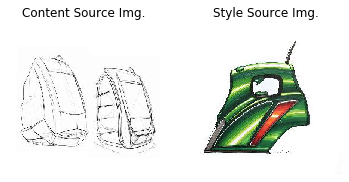

Iteration 0


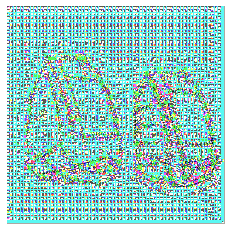

Iteration 100


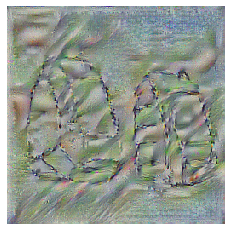

Iteration 199


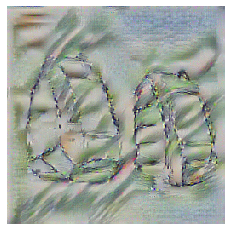

In [19]:
# Composition VII + Tubingen
params1 = {
    'content_image' : r'C:\Users\Hou Peizhe\Desktop\for the report\Dataset2\Dataset\train\A\1.jpg',
    'style_image' : r'C:\Users\Hou Peizhe\Desktop\for the report\Dataset2\Dataset\train\B\3.jpg',
    'image_size' : 256,
    'style_size' : 256,
    'content_layer' : 3,
    'content_weight' : 5e-3, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

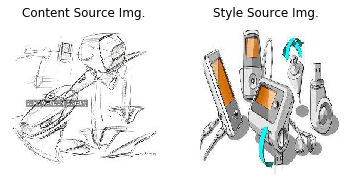

Iteration 0


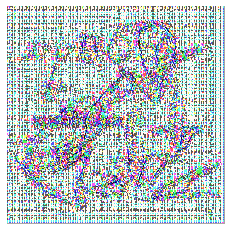

Iteration 100


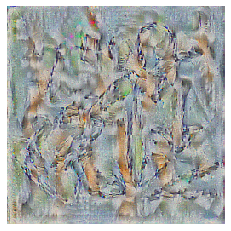

Iteration 199


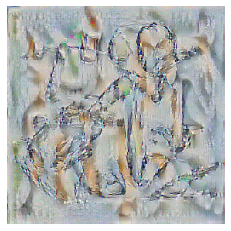

In [20]:
# Composition VII + Tubingen
params1 = {
    'content_image' : r'C:\Users\Hou Peizhe\Desktop\for the report\Dataset2\Dataset\train\A\44.jpg',
    'style_image' : r'C:\Users\Hou Peizhe\Desktop\for the report\Dataset2\Dataset\train\B\55.jpg',
    'image_size' : 256,
    'style_size' : 256,
    'content_layer' : 3,
    'content_weight' : 5e-3, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)